# Моделирование решения уравнения теплопроводности в плоскости
Рассмотрим решения стационарного уравнения теплопроводности
в 2D случае.
Это уравнение имеет вид

In [103]:
display(equation)

<IPython.core.display.Latex object>

S(x, y) - мощность источника тепла в единице объема

0 <= x <= L<sub>x</sub>

0 <= y <= L<sub>y</sub>

Так как источниковый член S может зависеть от T , желательно учесть эту зависимость в линеаризованной форме
S=S<sub>c</sub>+S<sub>p</sub>T<sub>p</sub>


Уравнение относится к уравнению эллиптического типа. И мы будем
решать его итерационным методом.


Для простоты будем рассматривать случай равномерной сетки в продольном и поперечном
направлениях. Применим метод блочной итерации с переменными направлениями (метод
продольно-поперечной прогонки)

Если на всех 4-х границах расчетной области заданы граничные условия (1-го, 2-го или 3-го рода), 
то такая краевая задача поставлена корректно.

Однако в практических расчетах необходимо уметь задавать различные граничные условия внутри расчетной области,
при этом продолжая использовать метод продольно-поперечной прогонки с граничными условиями на внешних границах.

На рисунке изображены граничные условия и распределение внутренних областей
где T- температуры , а Q- потоки

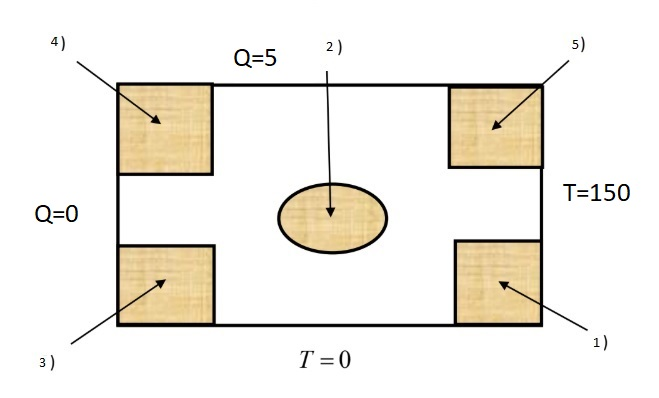

In [44]:
Image(filename="Zone_distibution.jpg")

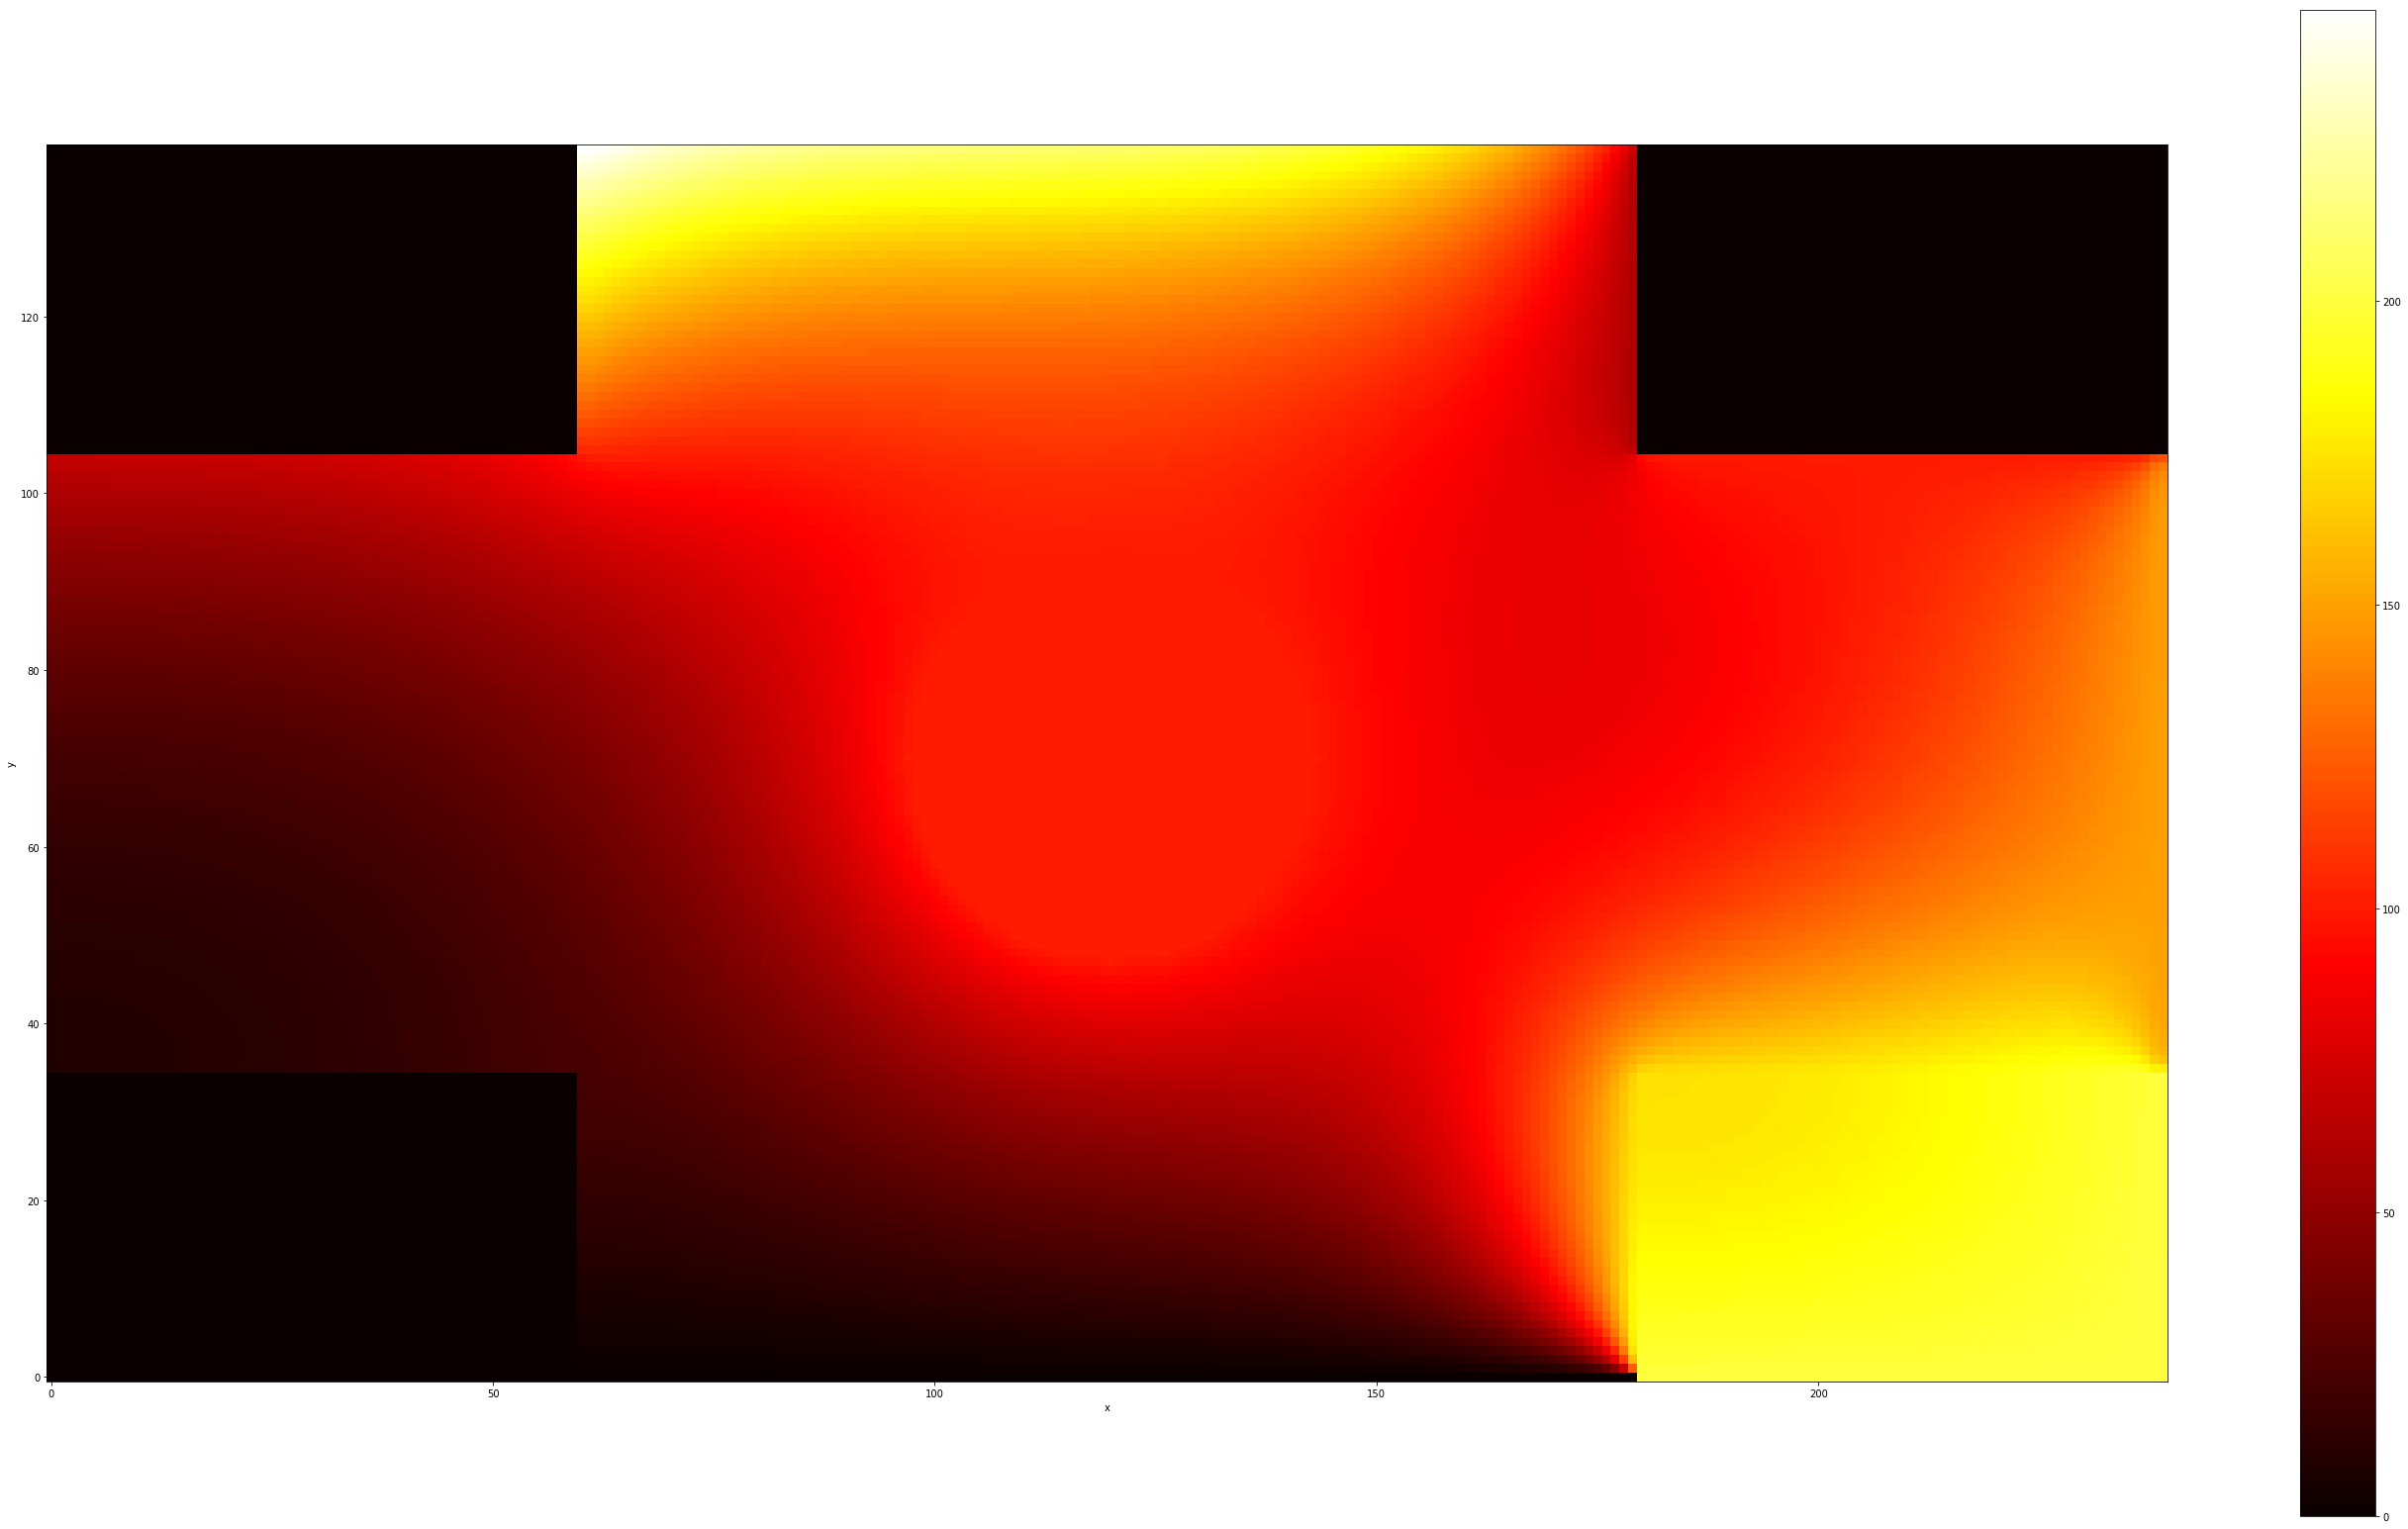

In [77]:
showT(T)

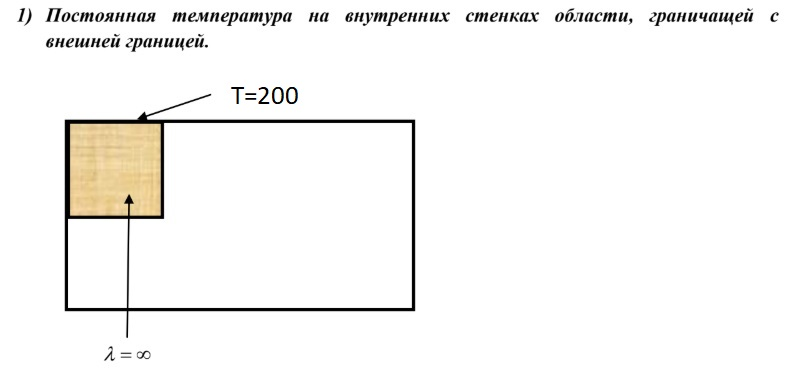

In [45]:
Image(filename="zone1.jpg")

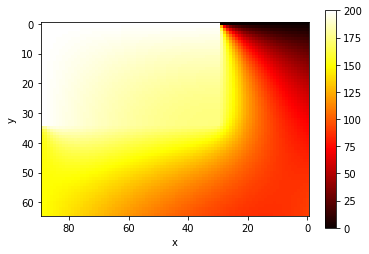

In [93]:
showZone(1)

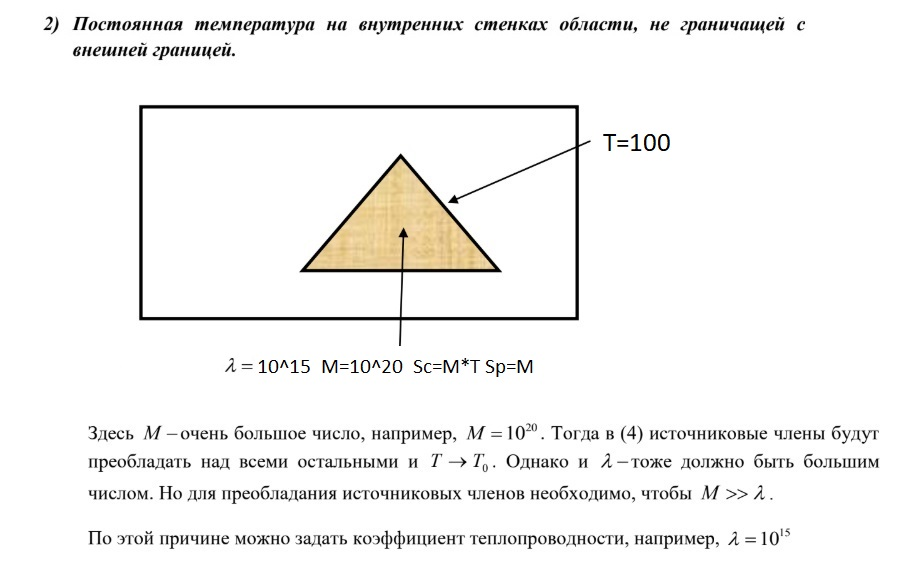

In [47]:
Image(filename="zone2.jpg")

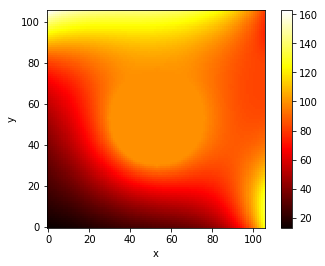

In [94]:
showZone(2)

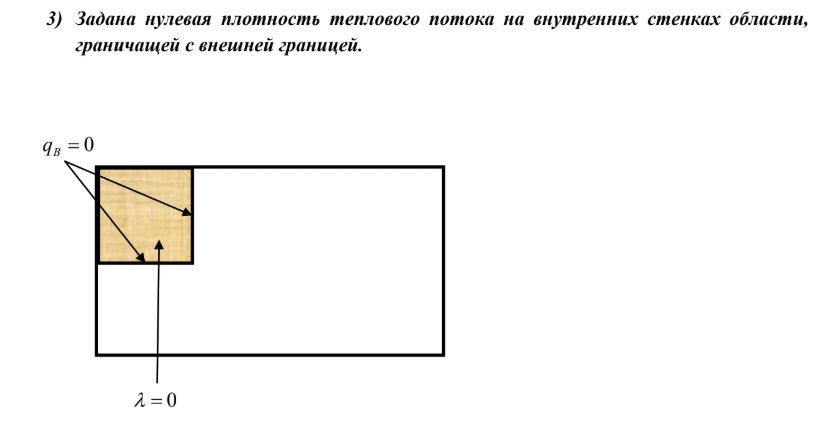

In [48]:
Image(filename="zone3.jpg")

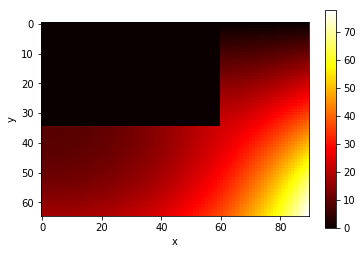

In [95]:
showZone(3)

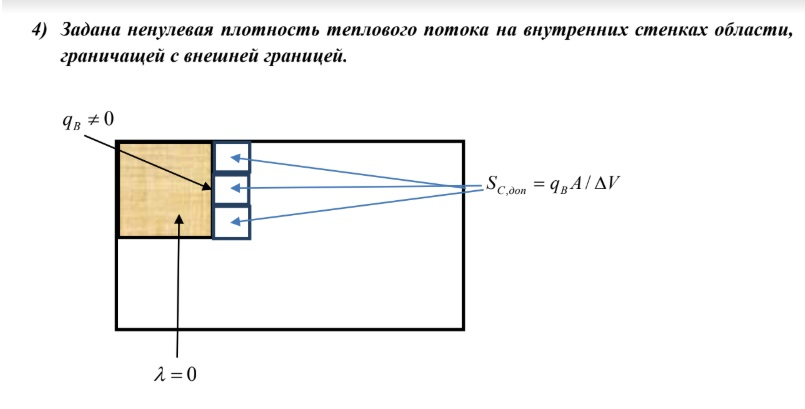

In [49]:
Image(filename="zone4.jpg")

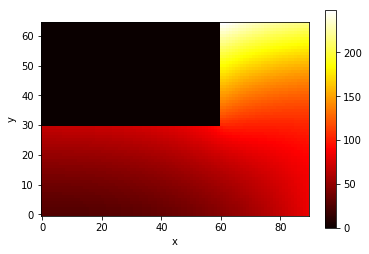

In [96]:
showZone(4)

# 5) Заданы различные значения температуры на внутренних стенках в области,граничащей с внешней границей.

Для этого необходимо рассмотреть вспомогательную задачу о конвективном теплообмене на
границе между окружающей средой с температурой T=T<sub>inf</sub> и рассматриваемой расчетной
областью. Пусть температура на границе T=T<sub>B</sub> 

Тогда тепловой поток, идущий из
окружающей среды на границу, равен Q=h(T<sub>inf</sub>-T<sub>B</sub>) , где
h - коэффициент теплоотдачи.

Этот же поток входит в первую ячейку расчетной области:
Q=2*lambda*(T<sub>inf</sub>-T<sub>P</sub>)/x_step. 

Исключив температуру T<sub>B</sub> , имеем Q=(1/h+x_step/(2*lambda))^(-1)*(T<sub>inf</sub>-T<sub>P</sub>). 

Если коэффициент теплоотдачи будет большим, то T<sub>B</sub> -> T<sub>inf</sub>
, поскольку тепловой поток - ограниченная величина. 

Поэтому
достаточно задать дополнительные источниковае члены в соседних с границей ячейках (как
на рисунке), чтобы обеспечить нужное значение температуры на внутренней границе.

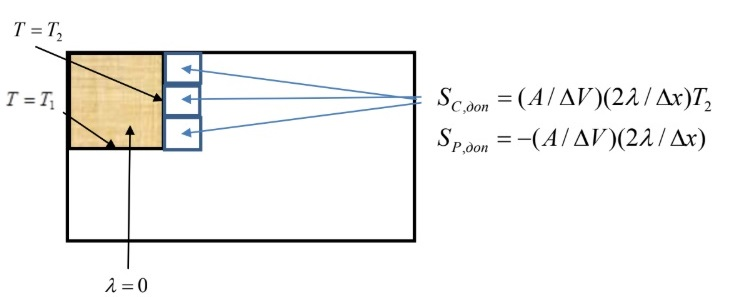

In [51]:
Image(filename="zone5_1.jpg")

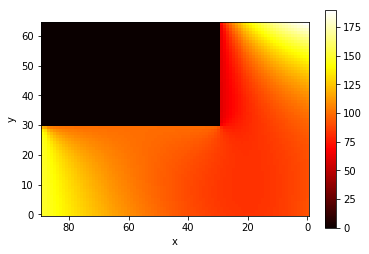

In [97]:
showZone(5)

In [6]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
from IPython.display import HTML
import math
from IPython.display import display, Math, Latex
from IPython.display import Image

In [21]:
#Задание значений температур и потоков
T_low = 0
Q_up = 5
Q_left = 0
T_right = 150
T_one=200

T_init_circle = 100
Lambda_circle=10**15
Lambda_init = 10 ** 20

M_circle= 10 ** 20

Q_4 = 2

T_init_5 = 100
T_init_5_ = 60

In [98]:
#Задание условий внутри и на границах областей

border_size_x = x_number // 4
border_size_y = y_number // 4
radius = y_number // 6

# first area
lambdas[-border_size_x:,:border_size_y]=Lambda_init

#second area
cx=x_number//2
cy=y_number//2
for i in range(cx-radius,cx+radius+1):
    for j in range(cy-radius,cy+radius+1):
        dist=(i-cx)**2+(j-cy)**2
        if (dist<=radius**2):
            lambdas[i,j]=Lambda_circle
            source_c[i,j]=M_circle * T_init_circle
            source_p[i,j]=M_circle


#third area
lambdas[:border_size_x,:border_size_y]=0
source_c[border_size_x+1,:border_size_y]=0
source_c[:border_size_x,border_size_y+1]=0

#fourth area
lambdas[:border_size_x,-border_size_y:]=0

source_c[border_size_x+1,-border_size_y:]=Q_4
source_c[:border_size_x,-border_size_y-1]=Q_4

#fifth area

lambdas[-border_size_x:,-border_size_y:]=0

source_c[-border_size_x:,-border_size_y-1]=(2*lambdas[-border_size_x:,-border_size_y-1]* T_init_5 / x_step)
source_p[-border_size_x:,-border_size_y-1]=(2*lambdas[-border_size_x:,-border_size_y-1]/x_step)

source_c[-border_size_x-1,-border_size_y:]=(2*lambdas[-border_size_x-1,-border_size_y:]* T_init_5_ / x_step)
source_p[-border_size_x-1,-border_size_y:]=(2*lambdas[-border_size_x-1,-border_size_y:]/ x_step)

In [52]:
x_length = 240
y_length = 140

x_number = 240
y_number = 140

x_range = np.linspace(0, x_length, x_number)
y_range = np.linspace(0, y_length, y_number)

x_step = x_range[1] - x_range[0]
y_step = y_range[1] - y_range[0]

X, Y = np.meshgrid(x_range, y_range, indexing='ij')

T = np.zeros_like(X)
lambdas = np.ones_like(X)
source_c = np.zeros_like(X)
source_p = np.zeros_like(X)

In [56]:
#Рассчет по схеме продольно-поперечной прогонки
with tqdm.tqdm_notebook() as pbar:
    while True:
        T_prev = T.copy()
        counter+=1
        T = run(T, source_c, source_p, lambdas, 'cross')
        T = run(T, source_c, source_p, lambdas, 'long')
    
        T_difference = abs(T_prev - T)
    
        if np.amax(T_difference) < 0.15:
            break
    
        pbar.update(1)
        pbar.set_description(f"T diff: {T_difference.max():.5f}")
        pbar.refresh()

NameError: name 'tqdm' is not defined

In [28]:
#Подсчет прогоночных коэффициентов 
def run_coeffs(alpha, beta, u, up_u, low_u, s_c, s_p, l, up_l, low_l, run_type):
    if run_type == 'long':
        size_x = x_step
        size_y = y_step
    
    elif run_type == 'cross':
        size_x = y_step
        size_y = x_step
    
    with np.errstate(divide='ignore', invalid='ignore'):
    
        a = np.roll(l, 1) / (np.roll(l, 1) + l) / size_x ** 2
        b = np.roll(l, -1) / (np.roll(l, -1) + l) / size_x ** 2
        c = (
        ((np.roll(l, -1) + np.roll(l, 1)) * l +
        2 * np.roll(l, -1) * np.roll(l, 1)) /
        (np.roll(l, -1) + l) /
        (np.roll(l, 1) + l) /
        size_x ** 2 +
        ((up_l + low_l) * l +
        2 * up_l * low_l) /
        (up_l + l) /
        (low_l + l) /
        size_y ** 2 +
        s_p / (2 * l)
        )
        d = (
        up_l / (up_l + l)
        * up_u / size_y ** 2 +
        low_l / (low_l + l)
        * low_u / size_y ** 2 +
        s_c / (2 * l)
        )
    
    for i in range(1, len(u)-1):
        alpha[i+1] = b[i] / (c[i] - alpha[i] * a[i])
        beta[i+1] = (a[i] * beta[i] + d[i]) / (c[i] - alpha[i] * a[i])
        if math.isnan(alpha[i+1]):
            alpha[i+1] = 0
        if math.isnan(beta[i + 1]):
            beta[i + 1] = u[i]
    
    return alpha, beta

In [29]:
#Граничные условия в областях при поперечной прогонке
def cross_init(k, l, alpha_last, beta_last, stage):

    if k >= border_size_y and k < y_number - border_size_y: #background
        alpha = 1
        beta = 0
        
        u = T_right
    
    elif k <= border_size_y: #third and first
        alpha = 0
        beta = 0
        
        u = T_one
    
    else: #fifth and fourth area
        alpha = 0
        beta = 0
        
        u = 0
        
    if stage == 'start':
        return alpha, beta
    else:
        return u

#Граничные условия в областях при продольной прогонке
def long_init(m, l, alpha_last, beta_last, stage):
    if m >= border_size_x and m < x_number - border_size_x:
        alpha = 0
        beta = T_low
        
        u = (y_step * Q_up / l[-1] + beta_last) / (1 - alpha_last)
        
    elif m <= border_size_x:#third and fourth
        alpha = 0
        beta = 0
        
        u = 0
    
    else:#fifth and first
        alpha = 0
        beta = T_one
        
        u = 0
    
    if stage == 'start':
        return alpha, beta
    else:
        return u

In [60]:
#алгоритм прогонки
def run(U, S_c, S_p,lambdas, run_type):

    if run_type == 'long':
        U = U.T
        S_c = S_c.T
        S_p = S_p.T
        lambdas = lambdas.T
    U_prev = U.copy()
    for k in range(0, len(U[1,:])):
    
        u = U_prev[:, k]
        
        s_c = S_c[:, k]
        s_p = S_p[:, k]
        
        l = lambdas[:, k]
        
        if k is not 0:
            low_l = lambdas[:, k-1]
            low_u = U_prev[:, k-1]
        else:
            low_l = lambdas[:, 0]
            low_u = U_prev[:, 0]
        
        try:
            up_u = U_prev[:, k+1]
            up_l = lambdas[:, k+1]
        except IndexError:
            up_u = U_prev[:, k]
            up_l = lambdas[:, k]
        
        alpha = np.zeros_like(u)
        beta = np.zeros_like(u)
        
        
        #Рассчет прогоночных коэффициентов
        if run_type == 'long':
            alpha[1], beta[1]= long_init(k, l, alpha[-1], beta[-1], 'start')
        
        if run_type == 'cross':
            alpha[1], beta[1]= cross_init(k, l, alpha[-1], beta[-1], 'start')
        
        alpha, beta = run_coeffs(alpha, beta, u, up_u, low_u, s_c, s_p,
        l, up_l, low_l, run_type)
        
        #Граничные условия
        if run_type == 'long':
            U[-1, k] = long_init(k, l, alpha[-1], beta[-1], 'end')
        
        if run_type == 'cross':
            U[-1, k] = cross_init(k, l, alpha[-1], beta[-1], 'end')
        
        #Рассчет значений
        for m in reversed(range(0, len(U[:, 1]) - 1)):
            U[m, k] = alpha[m+1] * U[m+1, k] + beta[m+1]
    
    
    if run_type == 'long':
        return U.T
    
    if run_type == 'cross':
        return U

In [99]:
def showT(T):
    plt.figure(figsize = (48,28))
    plt.imshow(T.T,cmap='hot',interpolation='nearest')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    ax=plt.gca()
    ax.invert_yaxis()
    plt.savefig("temp")

In [101]:
def showZone(num):
    if num==1:
        newT=(T[-border_size_x-30:,:border_size_y+30]).T
        plt.imshow(newT,cmap='hot',interpolation='nearest')
        plt.colorbar()
        plt.xlabel('x')
        plt.ylabel('y')
        ax=plt.gca()
        ax.invert_xaxis()
    if num==2:
        newT=(T[cx-radius-30:cx+radius+30,cy-radius-30:cy+radius+30]).T
        plt.imshow(newT,cmap='hot',interpolation='nearest')
        plt.colorbar()
        plt.xlabel('x')
        plt.ylabel('y')
        ax=plt.gca()
        ax.invert_yaxis()
    if num==3:
        newT=(T[:border_size_x+30,:border_size_y+30]).T
        plt.imshow(newT,cmap='hot',interpolation='nearest')
        plt.colorbar()
        plt.xlabel('x')
        plt.ylabel('y')
        ax=plt.gca()
    if num==4:
        newT=(T[:border_size_x+30,-30-border_size_y:]).T
        plt.imshow(newT,cmap='hot',interpolation='nearest')
        plt.colorbar()
        plt.xlabel('x')
        plt.ylabel('y')
        ax=plt.gca()
        ax.invert_yaxis()
    if num==5:
        newT=(T[-border_size_x-30:,-border_size_y-30:]).T
        plt.imshow(newT,cmap='hot',interpolation='nearest')
        plt.colorbar()
        plt.xlabel('x')
        plt.ylabel('y')
        ax=plt.gca()
        ax.invert_yaxis()
        ax.invert_xaxis()  